### Import packages


In [31]:
from pathlib import Path
import logging

import pandas as pd
import numpy as np
from scipy.optimize import fsolve
from numpy.random import rand,choice
import matplotlib.pyplot as plt

### Config

In [34]:
from matplotlib.font_manager import fontManager as fm
fm.addfont(Path('/usr/share/fonts/truetype/win/simkai.ttf'))
fm.addfont(Path('/usr/share/fonts/truetype/win/STSONG.TTF'))

In [37]:
plt.rcParams['font.sans-serif'] = ["STSONG",'SimKai']
plt.rcParams['axes.unicode_minus'] = False

### Const set


In [4]:
PATH_FIGURE_ROOT = Path("../figure")
ZERO = 1e-8

### Data reference


In [5]:
def get_degree_arc(alpha):
    return alpha*2*np.pi/360

def get_degree_angle(alpha):
    return alpha*360/(2*np.pi)

def r2xy(r,theta):
    return r*np.cos(theta),r*np.sin(theta)

def xy2r(x,y):
    return np.sqrt(x**2,y**2),np.arctan(y/x)

def is_equal(a:np.float64,b:np.float64)->np.bool:
    return np.abs(a-b) < 1e-7

planes = ["FY00","FY01","FY02","FY03","FY04","FY05","FY06","FY07","FY08","FY09"]

radius = 100
arches = 0

divide_arch = 2*40*np.pi/360

cxs = [radius*np.cos(alpha) for alpha in np.arange(0,2*np.pi+0.1,0.1)]
cys = [radius*np.sin(alpha) for alpha in np.arange(0,2*np.pi+0.1,0.1)]

plane_series_tag = [1,2,3,4,5,6,7,8,9]

plane_series = np.array([(np.float64(ZERO),np.float64(ZERO)),*[(radius,x) for x in np.arange(ZERO,2*np.pi,40*2*np.pi/360)]])

plane_main_tag = [0,*[tag.item() for tag in choice(plane_series_tag,size=2,replace=False)]]

plane_main_tag.sort()

plane_main = [plane_series[plane_tag] for plane_tag in plane_main_tag]

plane_1 = plane_series[9] + [5*rand(),5*rand()]

plane_series
plane_series_xy = [r2xy(*p)for p in plane_series]
plane_main_xy = [r2xy(*p) for p in plane_main]

plane_positions_truth = [(i[0]+rand()-0.5,i[1]+rand()-0.5) for i in plane_series_xy[3:]]

### Calculate


In [6]:
def make_line(p1,p2):
    k = np.float64(p2[1]-p1[1])/np.float64(p2[0]-p1[0])
    vk = -1/k
    b = p1[1] - p1[0]*k
    vb = (p2[1]+p1[1])/2 - vk*(p2[0]+p1[0])/2
    alpha = np.arctan(k)
    return k,b,vk,vb,alpha,(p1[0]+p2[0])/2,(p1[1]+p2[1])/2

In [7]:
def get_line_length(p1,p2):
    return np.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)

In [8]:
def get_side_of_line(l,p):
    k,b,vk,vb,alpha,x,y = l
    if k != np.inf and k!= -np.inf:
        return p[1] > (k*p[0]+b)
    else:
        return p[0] > x

In [9]:
# if p and center on a line same side
def is_same_sade_of_circle(l,p,center1,center2,alpha):
    if get_side_of_line(l,p) == get_side_of_line(l,center1):
        if alpha <= np.pi/2:
            return center1
        else:
            return center2
    elif get_side_of_line(l,p) == get_side_of_line(l,center2):
        if alpha <= np.pi/2:
            return center2
        else:
            return center1
    else:
        return None

In [10]:
def routate(p:np.ndarray,alpha):
    return np.dot(p,np.array([[np.cos(alpha),np.sin(alpha)],[-np.sin(alpha),np.cos(alpha)]]))

$$P \times M + D = P' $$

$$
\begin{bmatrix}
x \\
y
\end{bmatrix}
\times
\begin{bmatrix}
\cos{\theta} & \sin{\theta} \\
-\sin{\theta} & \cos{\theta}
\end{bmatrix}
+
\begin{bmatrix}
x_{diff} \\
y_{diff}
\end{bmatrix}
=
\begin{bmatrix}
x'\\
y'
\end{bmatrix}
$$


In [11]:
def get_center(p1,p2,theta,pr):
    upset,p1,p2 = (False,p1,p2 )if p1[0] <= p2[0] else (True,p2,p1)
    k,b,vk,vb,alpha,x,y = make_line(p1,p2)
    
    l = get_line_length(p1,p2)
    radius = l/(2*np.sin(theta))
    
    center_origin_p = np.array([0,radius*np.cos(theta)])
    center_origin_n = np.array([0,-radius*np.cos(theta)])
    
    p2_origin = np.array([l/2,0])
    
    p_diff = p2 - routate(p2_origin,alpha)
    
    
    
    center_p = routate(center_origin_p,alpha)+p_diff
    center_n = routate(center_origin_n,alpha)+p_diff
    
    return is_same_sade_of_circle((k,b,vk,vb,alpha,x,y),pr,center_n,center_p,theta),radius

In [12]:
def get_angle(p1,p2,p):
    a = get_line_length(p1,p)
    b = get_line_length(p2,p)
    c = get_line_length(p1,p2)
    return np.arccos((a**2+b**2-c**2)/(2*a*b))

In [13]:
def location(ps,p):
    alpha_1 = get_angle(ps[0],ps[1],p)
    alpha_2 = get_angle(ps[0],ps[2],p)
    alpha_3 = get_angle(ps[2],ps[1],p)
    return alpha_1,alpha_2,alpha_3

In [14]:
get_degree_angle(get_angle((0,1),(1,1),(0,0)))

np.float64(44.999999999999986)

In [42]:
# get_center((0,0),(1,11),get_degree_arc(get_degree_angle(get_angle((0,1),(1,11),(0,0)))))

In [45]:
# get_center((1,2),(4,11),get_angle((1,2),(4,11),(1,6)))

In [46]:
def equation_1(phi,alpha,beta,theta):
    return np.sin(alpha)*np.sin(np.pi-phi-beta)-np.sin(beta)*np.sin(np.pi-alpha-theta+phi)

In [ ]:
def equtions_solve_d1_d2_d3(vars,alpha1,alpha2,alpha3,d01,d02,d03):
    def eq(vars):
        d1,d2,d3 = vars
        result1 = np.cos(alpha1) - (d1**2+d3**2 - d01**2)/(2*d1*d3)
        result2 = np.cos(alpha2) - (d2**2+d3**2 - d02**2)/(2*d2*d3)
        result3 = np.cos(alpha3) - (d1**2+d2**2 - d03**2)/(2*d1*d1)
        return [result1,result2,result3]
    return fsolve(eq,[1,1,1])

In [48]:
equtions_solve_d1_d2_d3([0,0,0],get_degree_arc(70),get_degree_arc(70),get_degree_arc(140),500,642.79)

array([342.02141519, 342.02141518, 499.99943214])

### Draw


In [21]:
def plot_line(base_point,other_points):
    for p in other_points:
        plt.plot([base_point[0],p[0]],[base_point[1],p[1]])

In [22]:
def circle(center, radius,color:str):
    xs = [(radius * np.cos(theta) + center[0]) for theta in np.arange(0, 2 * np.pi, 0.01)]
    ys = [(radius * np.sin(theta) + center[1]) for theta in np.arange(0, 2 * np.pi, 0.01)]
    plt.plot(xs,ys,color=color)

### Test


$$
P_{tr} \to P_{ex}
$$

<!-- 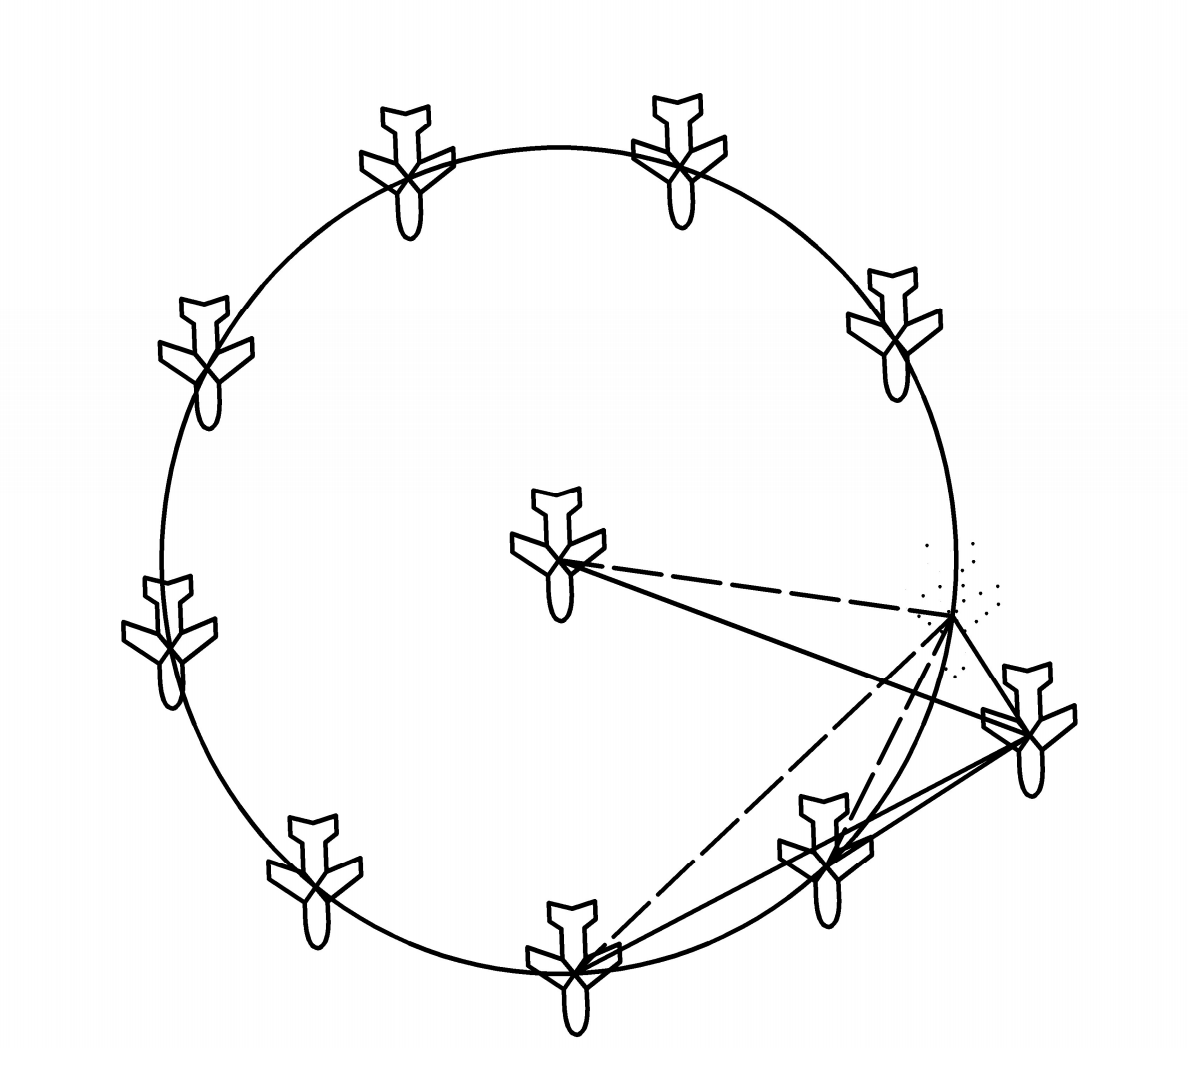 -->


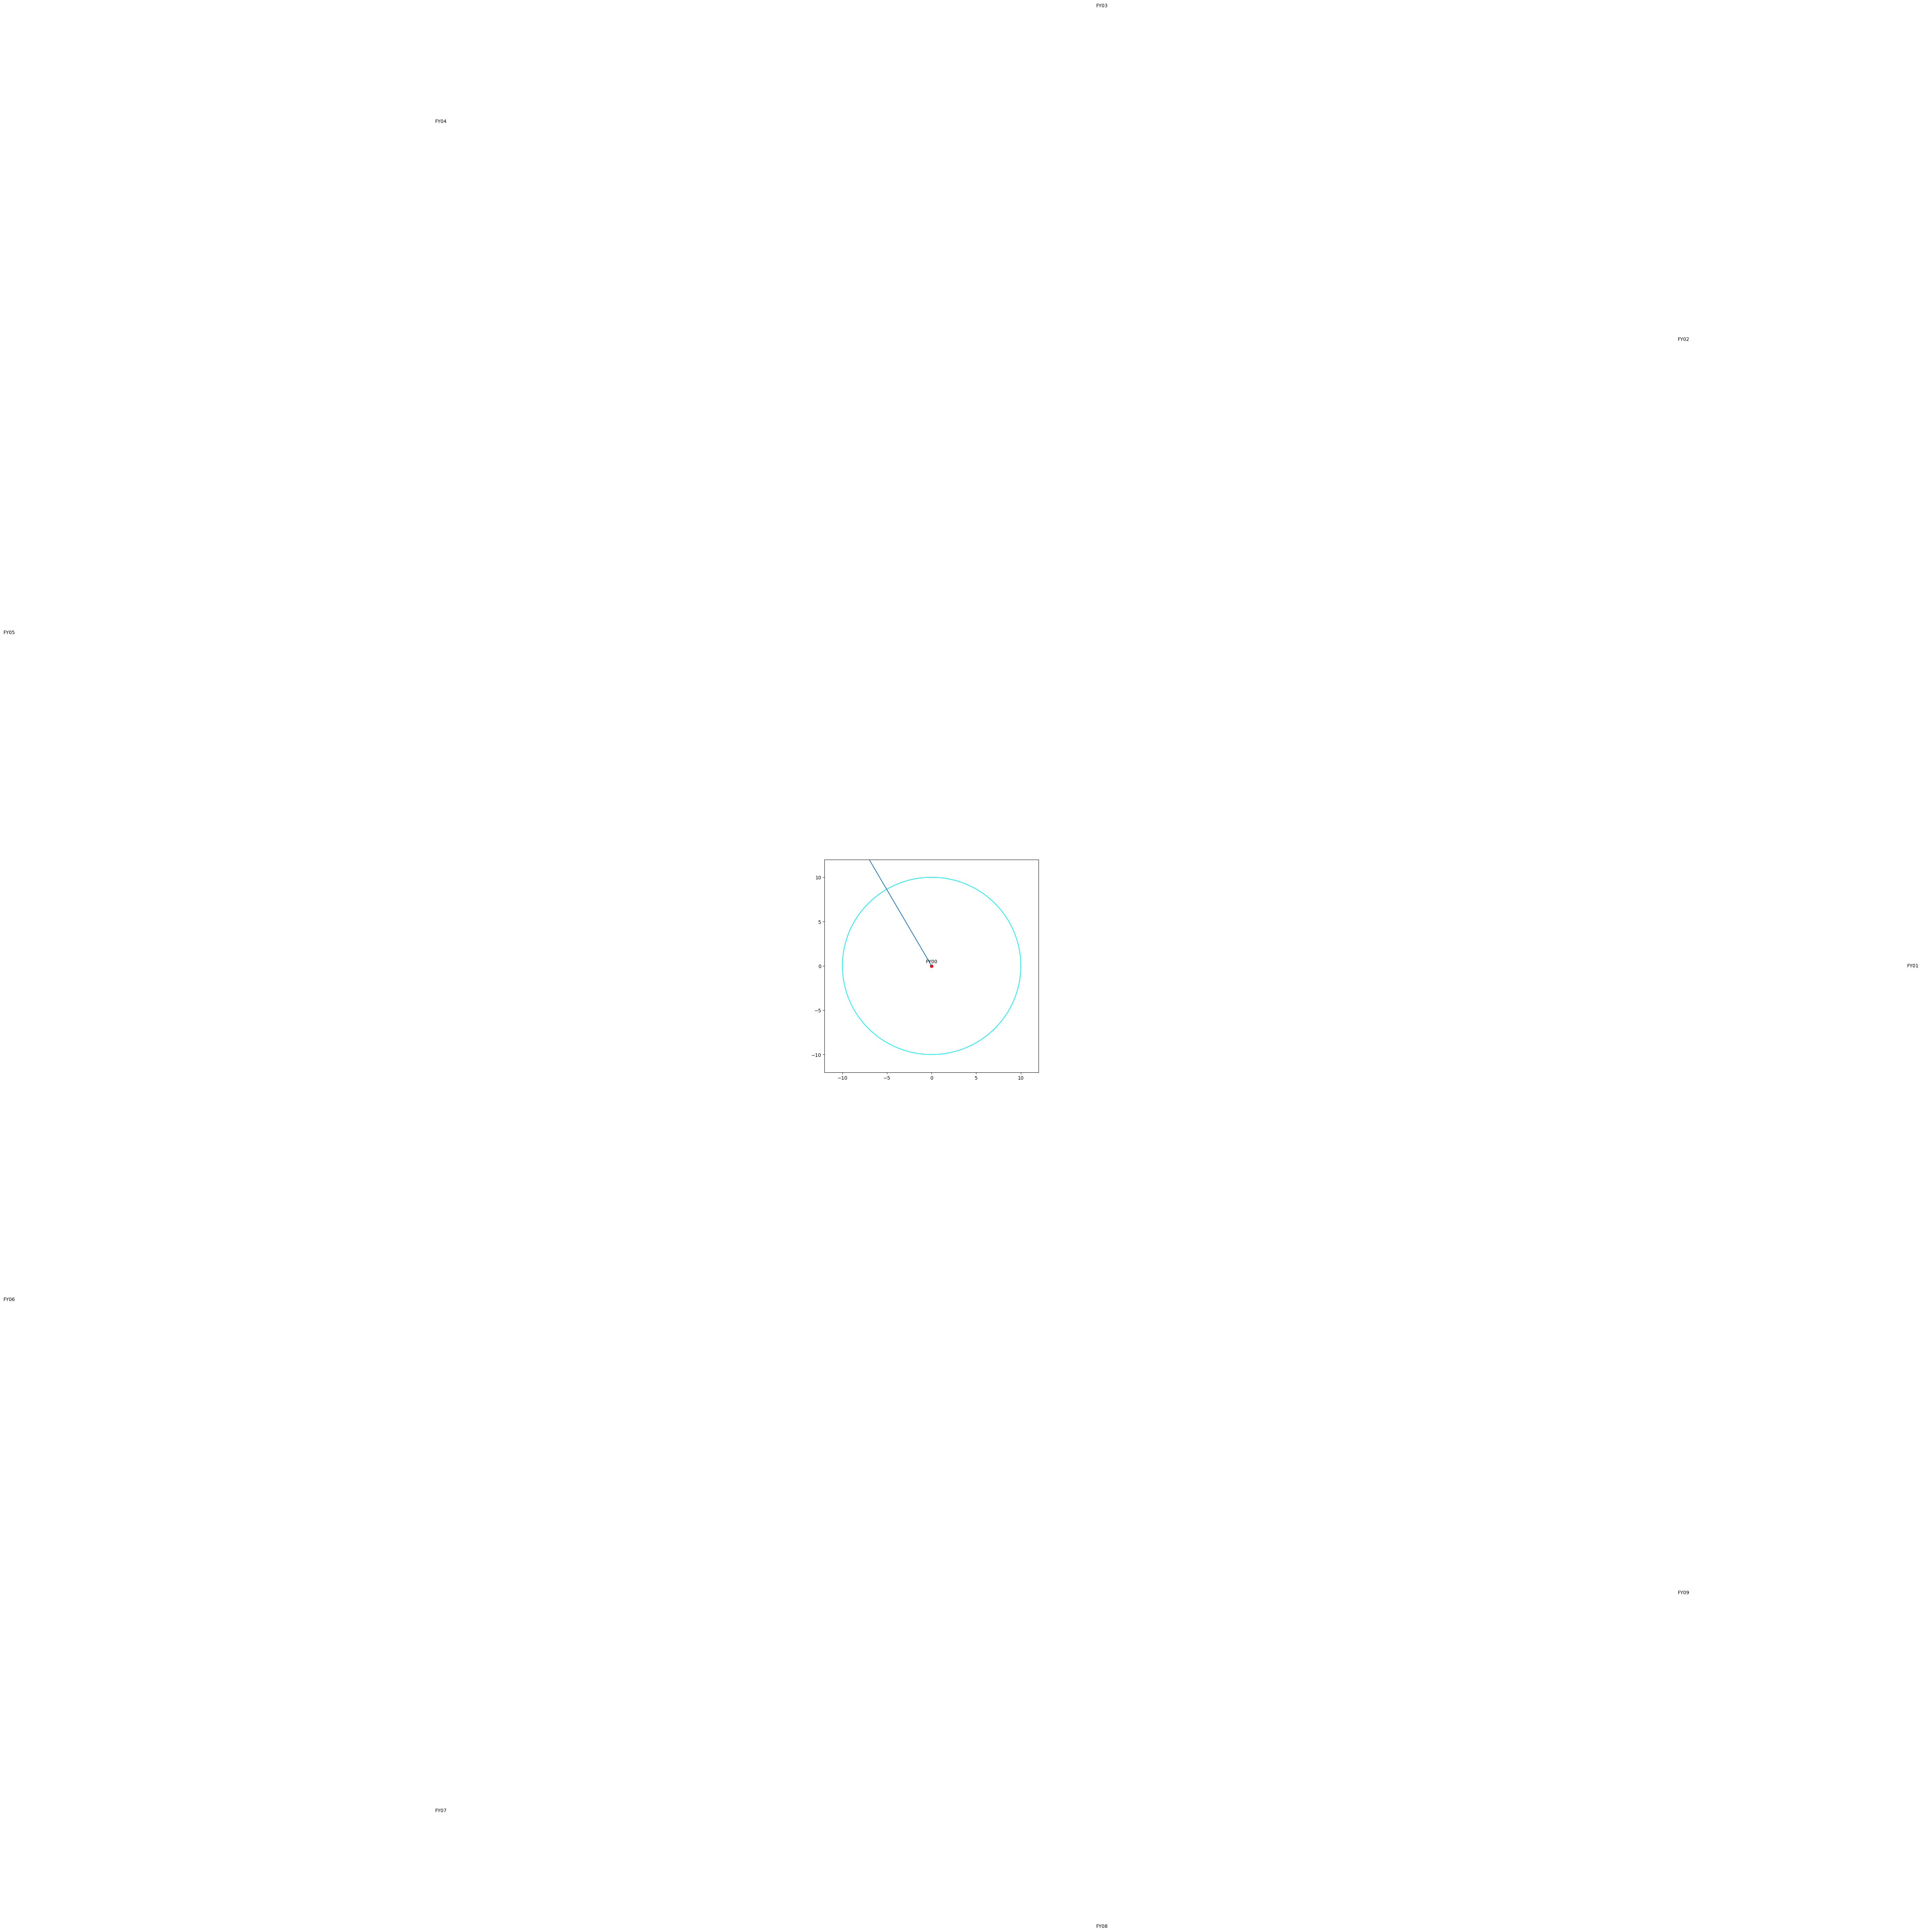

In [23]:

pre_p = plane_positions_truth[1]


plt.figure(figsize=(8,8))
for i, (x, y) in enumerate(plane_series_xy[:10]):
    if i != 0:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x * 1.1, y * 1.1, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移
    else:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x, y + 0.5, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移



plt.scatter(pre_p[0],pre_p[1],color="#F00FBB",marker="x")
circle((0,0),10,"#0FF0F0")

plot_line(pre_p,plane_main_xy)

alphas = location(plane_main_xy,pre_p)
c1,r1 = get_center(plane_main_xy[0],plane_main_xy[1],alphas[0],pre_p)
c2,r2 = get_center(plane_main_xy[0],plane_main_xy[2],alphas[1],pre_p)
c3,r3 = get_center(plane_main_xy[1],plane_main_xy[2],alphas[2],pre_p)

# circle(c1,r1,"#FF0000")
# circle(c2,r2,"#FF00FF")
# circle(c3,r3,"#F0F0F0")


plt.xlim([-12,12])
plt.ylim([-12,12])

plt.show()

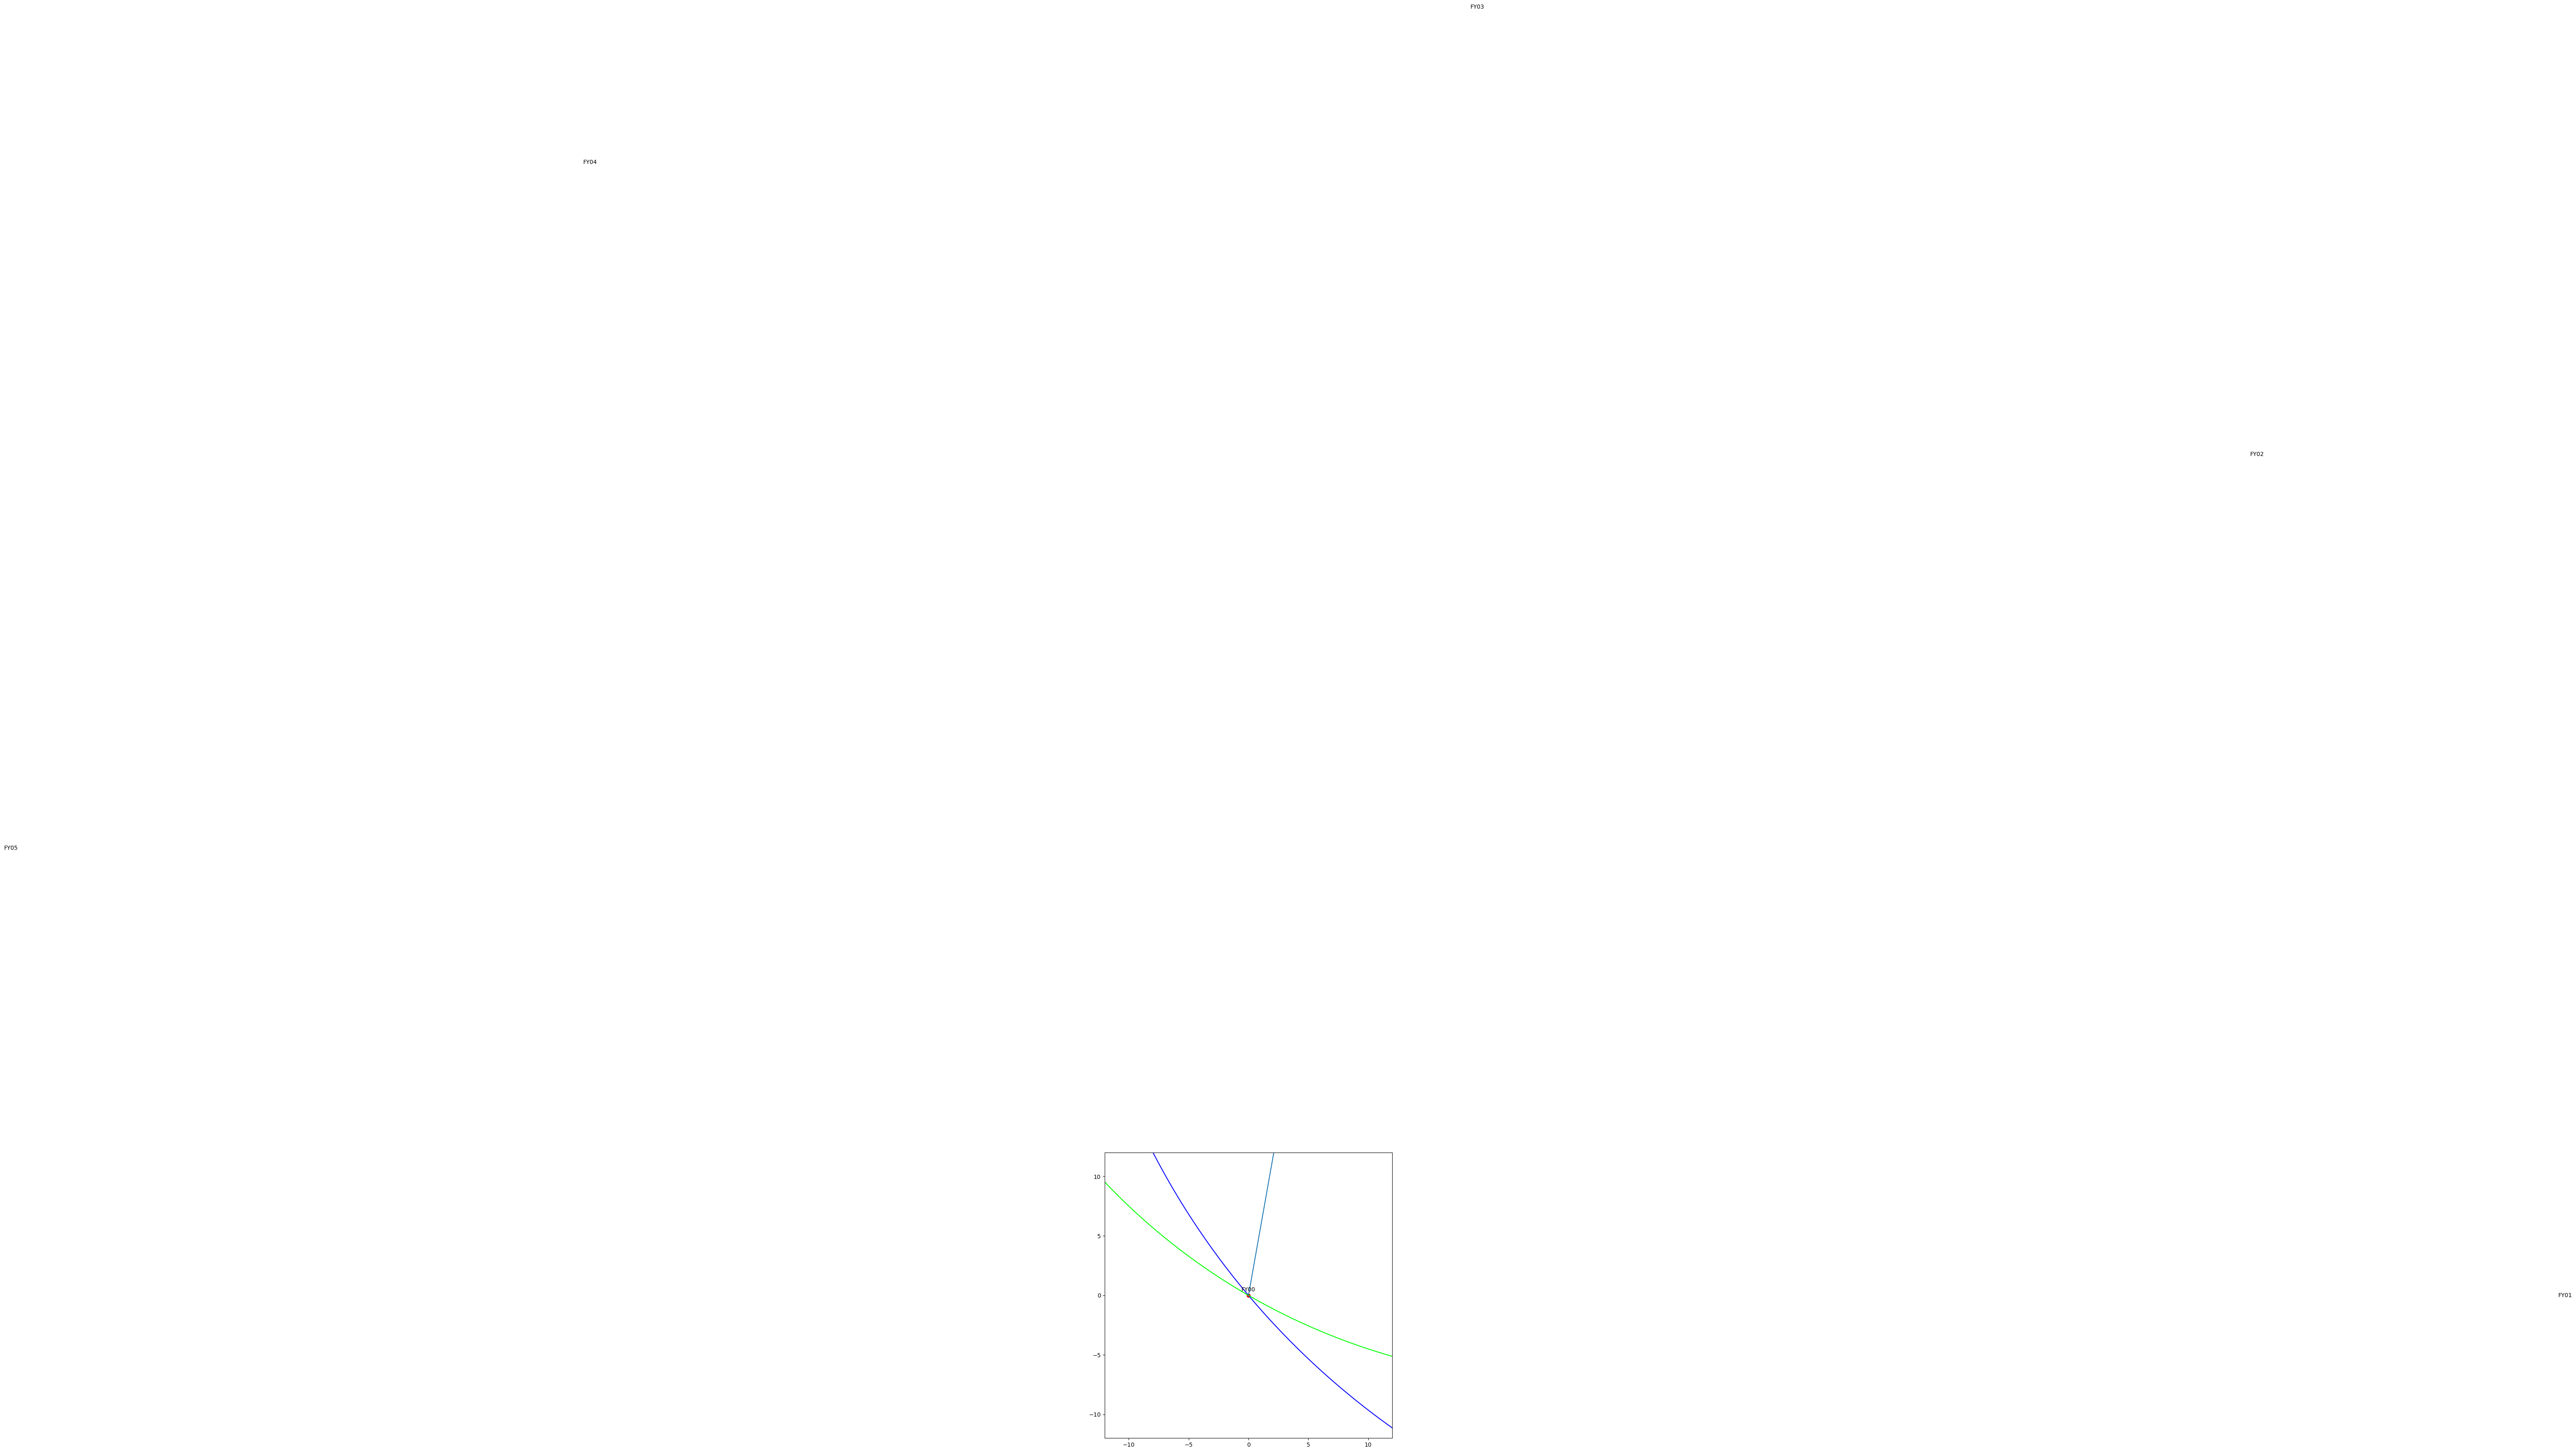

In [24]:
plt.figure(figsize=(9,9))
for i, (x, y) in enumerate(plane_series_xy[:6]):
    if i != 0:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x * 1.1, y * 1.1, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移
    else:
        plt.plot(x, y, "ro")  # 蓝色圆点
        plt.text(
            x, y + 0.5, planes[i], fontsize=10, ha="center", va="center"
        )  # 标签略外移
        
# for i,(x,y) in enumerate(plane_positions[1:4]):
#     plt.plot([0,x],[0,y])
plot_line(plane_positions_truth[0],plane_series_xy[:3])



for i, (x, y) in enumerate(plane_positions_truth):
    plt.plot(x,y,"x")
plt.xlim([-12,12])
plt.ylim([-12,12])
plt.plot(cxs, cys, color="#666666")

ls = location(plane_series_xy[0:3],plane_positions_truth[0])

c1,r1 = get_center(plane_series_xy[0],plane_series_xy[1],ls[0],plane_positions_truth[0])
c2,r2 = get_center(plane_series_xy[0],plane_series_xy[2],ls[1],plane_positions_truth[0])
c3,r3 = get_center(plane_series_xy[1],plane_series_xy[2],ls[2],plane_positions_truth[0])


# print(c1,c2,r)
# print(c1_2,c2_2,r_3)
# print(c1_3,c2_3,r_3)
circle(c1,r1,color="#0000FF")
circle(c2,r2,color="#00FF00")
circle(c3,r3,color="#FF0000")
# circle(c2_1,r_1,color="#0000FF")
# circle(c2_2,r_2,color="#00FF00")
# circle(c2_3,r_3,color="#FF0000")

# circle((3,3),5,"#0Ff0FF")
# plt.scatter(xs,ys,marker="x")
plt.show()

In [25]:
ps = [
    (0,0),
    (100,0),
    (98,40.10),
    (112,80.21),
    (105,119.75),
    (98,159.86),
    (112,199.96),
    (105,240.07),
    (98,280.17),
    (112,320.28)
]
ps_xy = [r2xy(p[0],get_degree_arc(p[1])) for p in ps]

In [26]:
ps_xy

[(np.float64(0.0), np.float64(0.0)),
 (np.float64(100.0), np.float64(0.0)),
 (np.float64(74.96229729000632), np.float64(63.124115716615876)),
 (np.float64(19.044201170560154), np.float64(110.36901015128855)),
 (np.float64(-52.10273288589687), np.float64(91.16087552135994)),
 (np.float64(-92.00770214648453), np.float64(33.74289178069635)),
 (np.float64(-105.27229068983148), np.float64(-38.23277145219296)),
 (np.float64(-52.38886563516713), np.float64(-90.99674036722637)),
 (np.float64(17.30380046043861), np.float64(-96.46024305186735)),
 (np.float64(86.14777204829524), np.float64(-71.57207116686621))]

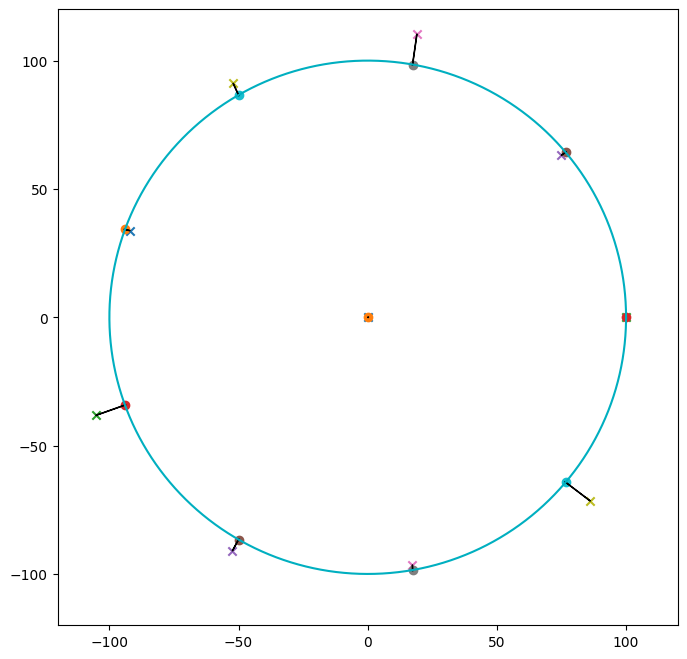

In [27]:
plt.figure(figsize=(8,8))
plt.xlim([-120,120])
plt.ylim([-120,120])

circle((0,0),100,"#00AFC0")

for i in range(0,10):
    plt.scatter(ps_xy[i][0],ps_xy[i][1],marker="x")
    plt.scatter(plane_series_xy[i][0],plane_series_xy[i][1],marker="o")
    plt.arrow(ps_xy[i][0],ps_xy[i][1],plane_series_xy[i][0]-ps_xy[i][0],plane_series_xy[i][1]-ps_xy[i][1],width=0.1)


In [28]:
def move_by_line():
    
    pass

def auto_find():
    pass

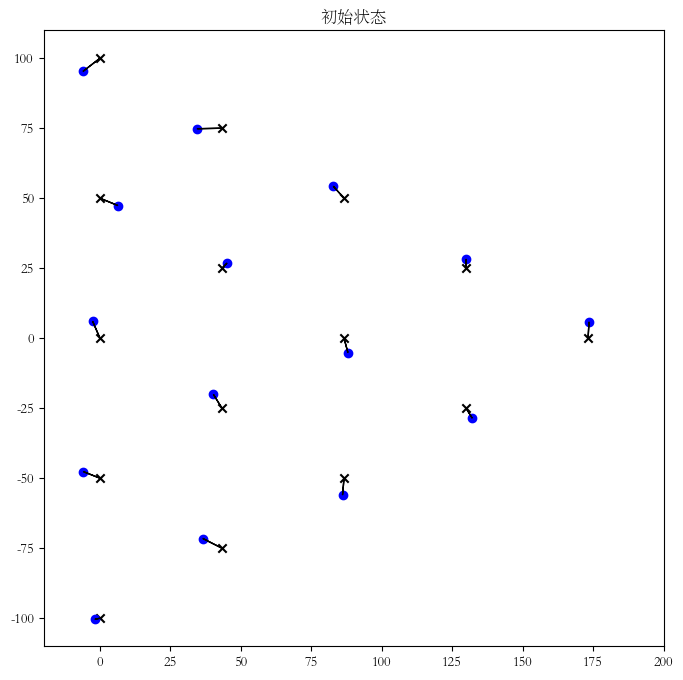

In [40]:
plt.figure(figsize=(8,8))
plt.xlim([-20,200])
plt.ylim([-110,110])

row = 5
length = 50

x_ps_1 = []
x_ps_2 = []

for i in range(row,0,-1):
    x_ps_1.append([((row-i)*length*np.sqrt(3)/2,y) for y in np.arange(-(i-1)*length/2,(i-1)*length/2+0.1,length)])
    x_ps_2.append([(x+rand()*10-rand()*10,y+rand()*10-rand()*10) for x,y in x_ps_1[len(x_ps_1)-1]])
    
for i in range(len(x_ps_1)):
    for j in range(len(x_ps_1[i])):
        
        plt.scatter(x_ps_1[i][j][0],x_ps_1[i][j][1],color="#000000",marker="x")
        plt.scatter(x_ps_2[i][j][0],x_ps_2[i][j][1],color="#0000FF",marker="o")
        plt.arrow(x_ps_1[i][j][0],x_ps_1[i][j][1],x_ps_2[i][j][0]-x_ps_1[i][j][0],x_ps_2[i][j][1]-x_ps_1[i][j][1])
plt.title("初始状态")
plt.show()